In [1]:
# processing
import numpy as np
import pandas as pd
from Bio import SeqIO

# custom packages
import tregs

# visualization
import matplotlib.pyplot as plt
import seaborn as sns
#plt.rcParams['figure.dpi'] = 150

### Loading input data

In [2]:
_genome = []
for record in SeqIO.parse("../../data/mg1655_genome.fasta", "fasta"):
    _genome.append(str(record.seq))
genome = _genome[0]

In [3]:
# Promoter
rnap_site = 'CAGGCTTTACACTTTATGCTTCCGGCTCGTATGTTGTGTGG'

# Operator sequence
rep_site = 'AATTGTGAGCGGATAACAATT'

## Find the transcription start site
df = pd.read_csv('../../data/ecoli_gene_list.csv')
lacZYA_TSS = int(df[(df.gene == 'lacZ') & (df.promoter == 'lacZp1')]['tss'].iloc[0])
promoter = tregs.seq_utils.get_regulatory_region(genome, lacZYA_TSS, reverse=True)

In [4]:
# obtained from https://journals.plos.org/ploscompbiol/article/figure?id=10.1371/journal.pcbi.1002811.g002

rnap_emat_raw = np.loadtxt('../../data/energy_matrices/RNAP_energy_matrix.txt')
rnap_emat = tregs.simulate.fix_wt(rnap_emat_raw, rnap_site)

In [5]:
O1_1027_raw = np.load('../../data/energy_matrices/lacThermoforTO1.npy')

O1_1027_fixed = np.zeros(np.shape(O1_1027_raw))
for i in range(3):
    O1_1027_fixed[i] = tregs.simulate.fix_wt(O1_1027_raw[i], rep_site)

rep_emat = np.mean(O1_1027_fixed, axis=0)

### Building information footprint when the number of RNAPs/repressors exists on a distribution

In [6]:
def simrep_pbound_with_noise(p_seq, r_seq, n_NS,
                             p_emat, r_emat, ep_wt, er_wt,
                             mean_p, mean_r, alpha):

    n_p_exponent = np.random.normal(np.log(mean_p), alpha * np.log(mean_p), 1)[0]
    n_r_exponent = np.random.normal(np.log(mean_r), alpha * np.log(mean_r), 1)[0]

    n_p_new = np.exp(n_p_exponent)
    n_r_new = np.exp(n_r_exponent)
    
    w_p = tregs.simulate.get_weight(p_seq, p_emat, e_wt=ep_wt)
    w_r = tregs.simulate.get_weight(r_seq, r_emat, e_wt=er_wt)

    z = np.zeros(3)
    z[0] = 1
    z[1] = n_p_new / n_NS * w_p
    z[2] = n_r_new / n_NS * w_r

    return z[1] / np.sum(z)

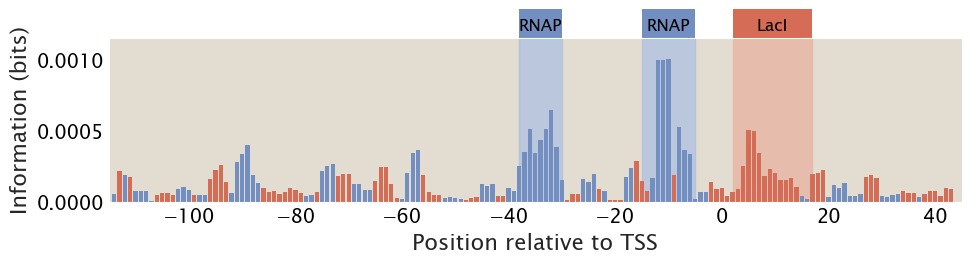

In [7]:
n_NS = len(genome)
ep_wt = -5
er_wt = -15

mean_p = 4600
mean_r = 10
alpha = 1

df = tregs.simulate.sim(promoter, simrep_pbound_with_noise, [rnap_site, rep_site], 
                        *[n_NS, rnap_emat, rep_emat, ep_wt, er_wt,
                          mean_p, mean_r, alpha])

region_params = [(-38, -30, 'P', 'RNAP'), (-15, -5, 'P', 'RNAP'), (2, 17, 'R', 'LacI')]
tregs.footprint.plot_footprint(promoter, df, region_params,
                               annotate_stn=False,
                               outfile='../rebuttal_plots/R4.pdf')

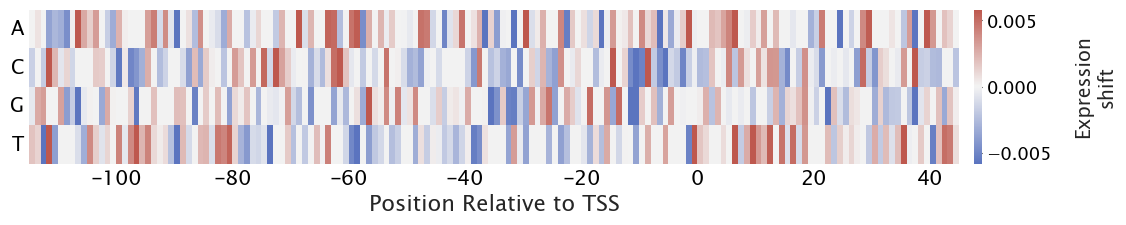

In [8]:
exshift = tregs.footprint.get_expression_shift_matrix(df, promoter)

fig, ax = plt.subplots(figsize=(15, 2))

vmax = np.max(np.abs(exshift)) * 0.5
vmin = -vmax

div_colors = sns.diverging_palette(258, 16, s=56, l=50, n=15, sep=5, center='light', as_cmap=True)
hm = sns.heatmap(exshift, cmap=div_colors, ax=ax, vmin=vmin, vmax=vmax, center=0)
ax.set_yticklabels(['A', 'C', 'G', 'T'], rotation=360, fontsize=14)
ax.set_xlabel('Position Relative to TSS', fontsize=16)

# Explicitly set the x-ticks to match your desired labels
tick_positions = np.arange(15, 161, 20)  # Adjust the divisor to match your number of labels
tick_labels = np.arange(-100, 41, 20)
ax.set_xticks(tick_positions)  # Set the positions for the x-ticks
ax.set_xticklabels(tick_labels, rotation=360, fontsize=15)  # Set the labels for the x-ticks and rotate them

# Access the colorbar and modify its properties
cbar = hm.collections[0].colorbar
cbar.ax.set_position([ax.get_position().x1 + 0.01, ax.get_position().y0, 0.02, ax.get_position().height])
cbar.set_label('Expression\nshift', rotation=90, labelpad=15, fontsize=14)
cbar.ax.tick_params(labelsize=13) 

#plt.tight_layout()
#plt.savefig('../plots/fig3/constitutive_exshift_matrix.pdf', bbox_inches='tight')
plt.show()